Updated: 27/02/24

This uses spatial mapping to identify the memory mode in the ringdown. 

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
import datetime 
import spherical
import quaternionic
import matplotlib.pyplot as plt
from qnmfitsrd.CCE_file_getter import *

In [76]:
sim = CCE_to_sim_simplified(sim_num='0305')

## How do $\theta$ curves look for different l,m? 

In [77]:
l_max = 4
n_max = 1
t0 = 10

theta_vals = np.linspace(-np.pi, np.pi, 200)
phi_vals = np.linspace(-np.pi/2, np.pi/2, 200)
theta, phi = np.meshgrid(theta_vals, phi_vals) 

wigner = spherical.Wigner(l_max)
R = quaternionic.array.from_spherical_coordinates(np.pi/2-phi, theta)
Y = wigner.sYlm(-2, R)

In [78]:
mapping = [(2,2,0,1,2,-2,0,-1)]

#spherical_modes = [(2,0)]
spherical_modes = [(l,0) for l in range(2,l_max+1)]
#spherical_modes = [(l,m) for l in range(2,l_max+1) for m in range(-l,l+1)]


"""QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]
"""

QNMs = [(lam, 0, n, p) for lam in np.arange(2, l_max+1) for n in np.arange(0,n_max+1) for p in (-1, +1)]
#QNMs = [(2,0,n,1) for n in range(1+1)] + [(2,0,n,-1) for n in range(1+1)]

print(mapping)
print(spherical_modes)
print(QNMs)

[(2, 2, 0, 1, 2, -2, 0, -1)]
[(2, 0), (3, 0), (4, 0)]
[(2, 0, 0, -1), (2, 0, 0, 1), (2, 0, 1, -1), (2, 0, 1, 1), (3, 0, 0, -1), (3, 0, 0, 1), (3, 0, 1, -1), (3, 0, 1, 1), (4, 0, 0, -1), (4, 0, 0, 1), (4, 0, 1, -1), (4, 0, 1, 1)]


In [79]:
best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                             sim.h,
                                             modes=QNMs,
                                             Mf=sim.Mf,
                                             chif=sim.chif_mag,
                                             t0=t0,
                                             mapping_modes=mapping,
                                             spherical_modes=spherical_modes) 

map = mapping[0]

bf_ans = np.zeros_like(theta, dtype=complex)

i = 0
for loop in range(len(best_fit['C'])):
    if best_fit['modes'][loop]==map:
        A = best_fit['C'][loop]
        bf_ans += A * Y[:,:,wigner.Yindex(*best_fit['spherical_modes'][i])]
        print(best_fit['modes'][loop])
        print(best_fit['spherical_modes'][i])
        print(A)
        i += 1
bf_ans /= np.max(np.abs(bf_ans))

(2, 2, 0, 1, 2, -2, 0, -1)
(2, 0)
(-0.019121482962413235-5.521326095815366e-09j)
(2, 2, 0, 1, 2, -2, 0, -1)
(3, 0)
(2.280452574195146e-07+0.003381753581853929j)
(2, 2, 0, 1, 2, -2, 0, -1)
(4, 0)
(-0.00045680780686303075-6.986920020207754e-10j)


Text(0.5, 1.0, 'Best Fit')

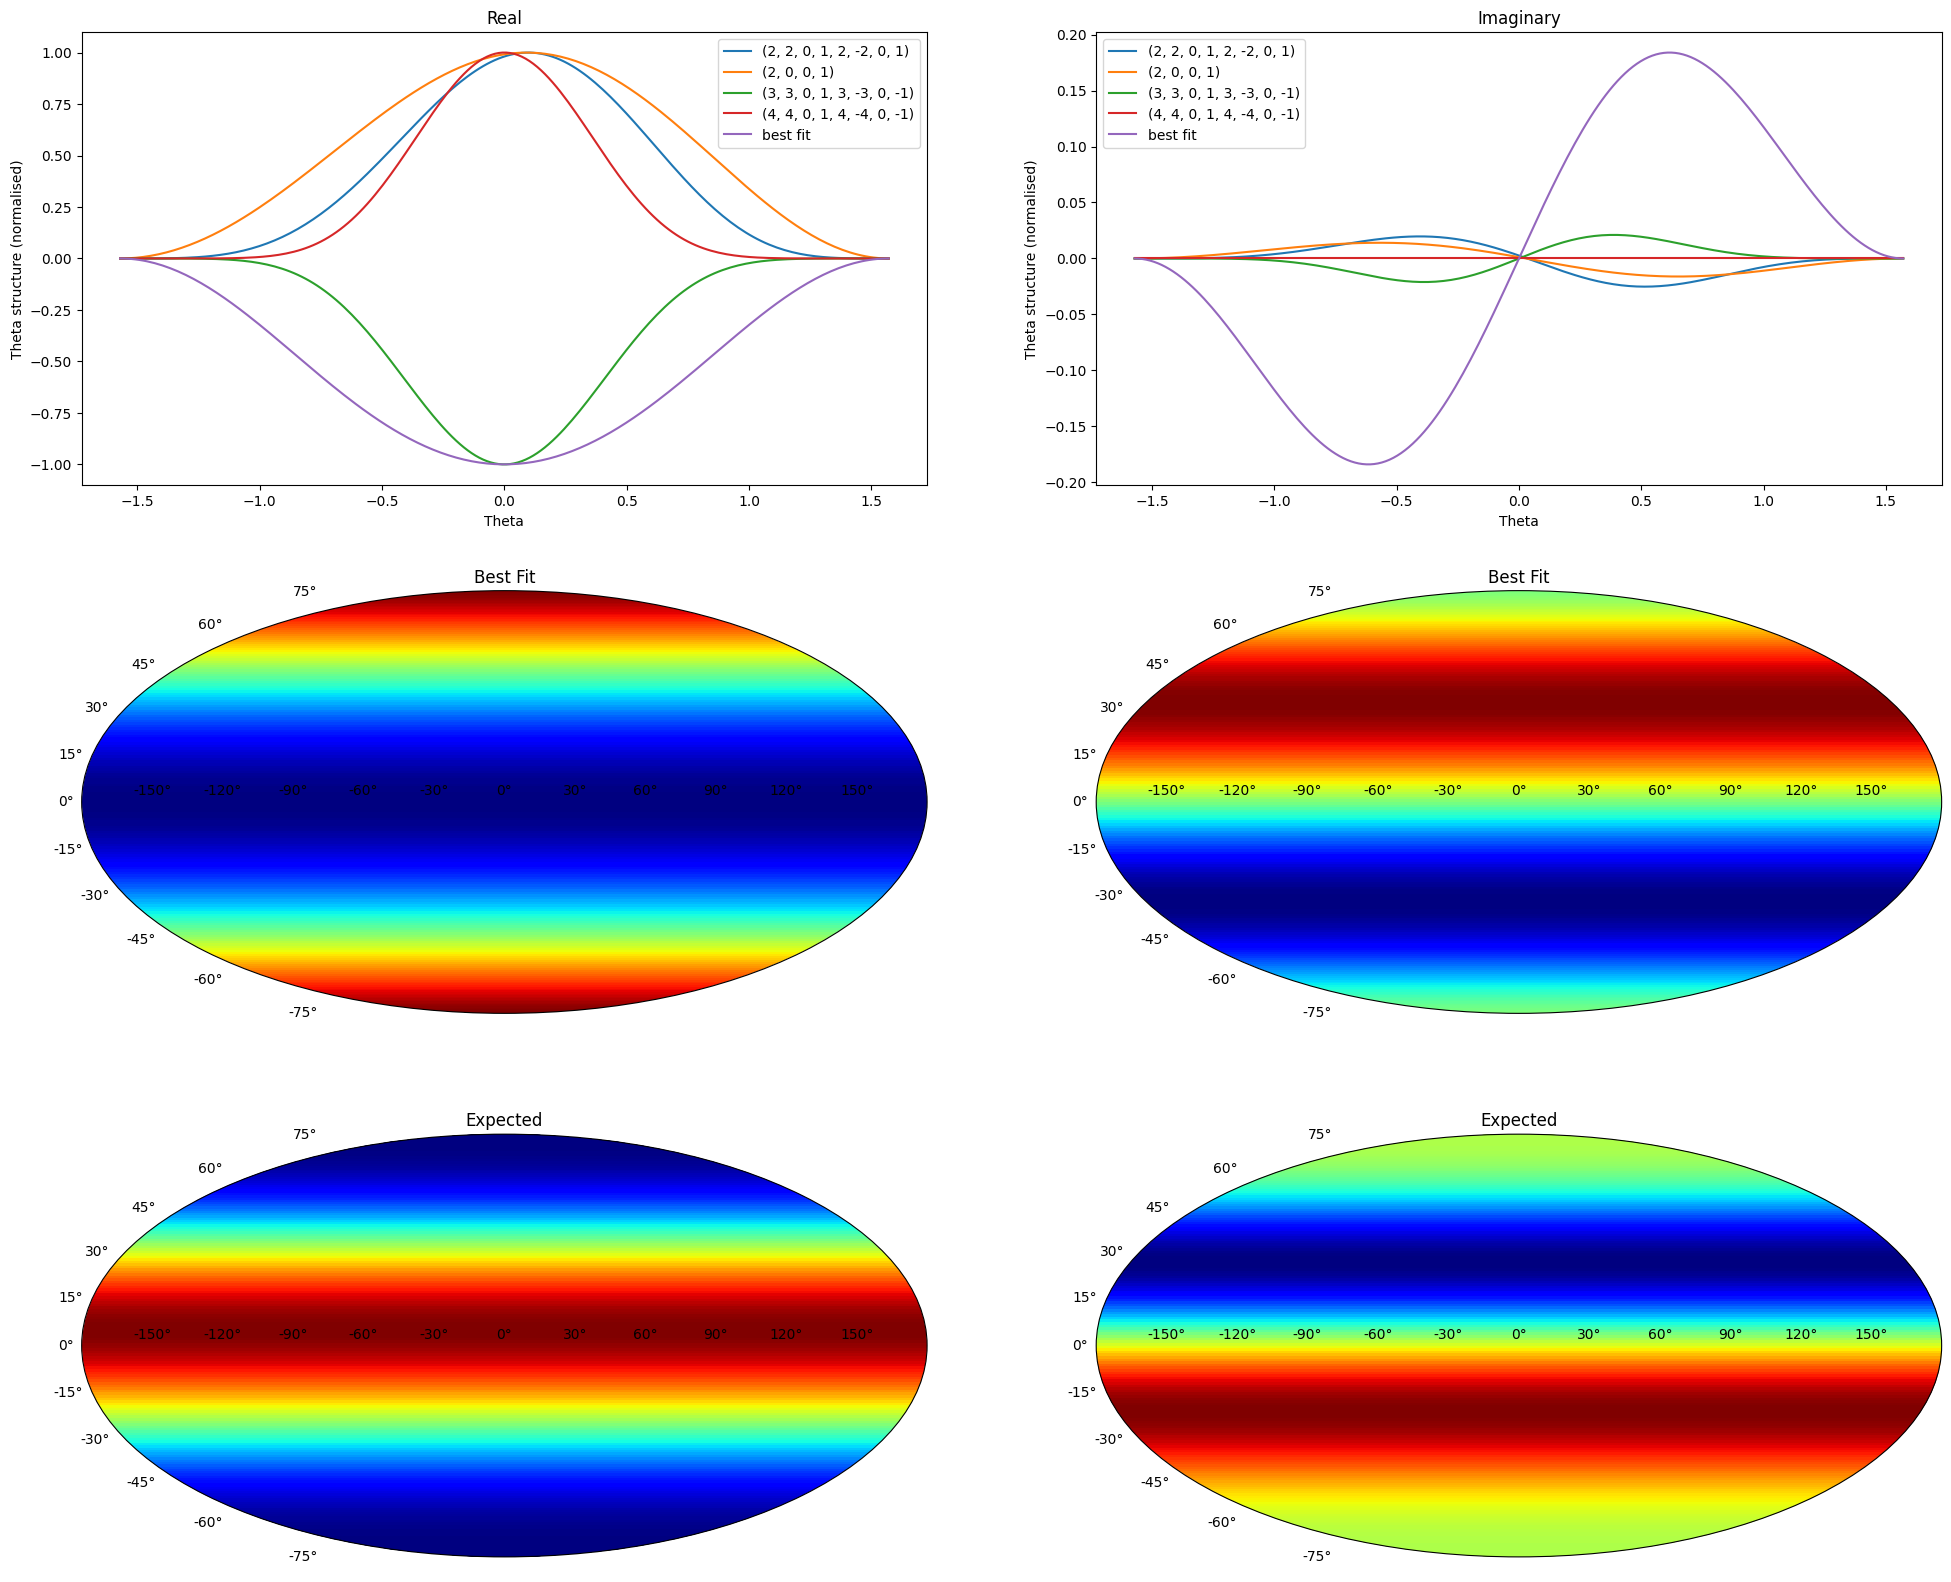

In [83]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,20))

test_qnms = [(2,2,0,1,2,-2,0,-1),(2,0,0,1), (3,3,0,1,3,-3,0,-1), (4,4,0,1,4,-4,0,-1)] 
#test_qnms = [(2,0,0,1), (2,-2,0,-1), (3,3,0,1), (3,-3,0,-1), (4,4,0,1), (4,-4,0,-1)] 

ax[2,0].axis('off')
ax[2,1].axis('off')
ax[2,0] = plt.subplot(3, 2, 5, projection='mollweide')
ax[2,1] = plt.subplot(3, 2, 6, projection='mollweide')

for map in test_qnms:
    ans = np.zeros_like(theta, dtype=complex)
    ans2 = np.zeros_like(theta, dtype=complex)
    if len(map)==4:
        l, m, n, p = map
        for lp in np.arange(2, l_max+1):
            ans += qnmfits.qnm.mu(lp, m, l, m, n, p, sim.chif_mag) * Y[:,:,wigner.Yindex(lp, m)]
    elif len(map)==8:
        a, b, c, sign1, e, f, g, sign2 = map
        for lp in np.arange(2, l_max+1):
            ans += qnmfits.qnm.mu(lp, b, a, b, c, sign1, sim.chif_mag) * Y[:,:,wigner.Yindex(lp, b)]
        for lp in np.arange(2, l_max+1):
            ans2 += qnmfits.qnm.mu(lp, f, e, f, g, sign2, sim.chif_mag) * Y[:,:,wigner.Yindex(lp, f)]
        ans = ans * ans2
    ans /= np.max(np.abs(ans)) 

    ax[0,0].plot(phi_vals, ans[:,100].real, label=str(map))
    ax[0,1].plot(phi_vals, ans[:,100].imag, label=str(map)) 

    if map == test_qnms[0]:
        ax[2,0].pcolormesh(theta, phi, np.real(ans), cmap=plt.cm.jet)
        ax[2,1].pcolormesh(theta, phi, np.imag(ans), cmap=plt.cm.jet)
        ax[2,0].set_title('Expected')
        ax[2,1].set_title('Expected')

ax[0,0].plot(phi_vals, bf_ans[:,100].real, label='best fit')
ax[0,0].set_xlabel('Theta')
ax[0,0].set_ylabel('Theta structure (normalised)')
ax[0,0].legend()
ax[0,0].set_title('Real')

ax[0,1].plot(phi_vals, bf_ans[:,100].imag, label='best fit')
ax[0,1].set_xlabel('Theta')
ax[0,1].set_ylabel('Theta structure (normalised)')
ax[0,1].legend()
ax[0,1].set_title('Imaginary')

ax[1,0].axis('off')  
ax[1,1].axis('off')  
ax[1,0] = plt.subplot(3, 2, 3, projection='mollweide')
ax[1,1] = plt.subplot(3, 2, 4, projection='mollweide')
ax[1,0].pcolormesh(theta, phi, np.real(bf_ans), cmap=plt.cm.jet)
ax[1,1].pcolormesh(theta, phi, np.imag(bf_ans), cmap=plt.cm.jet)
ax[1,0].set_title('Best Fit')
ax[1,1].set_title('Best Fit')


## Compare mapping for higher l memory modes

In [81]:
l_max = 4
n_max = 1
t0 = -10
step = 1

mappings = [[(2,2,0,1,2,2,0,1)],[(2,2,0,1,2,-2,0,-1)], [(3,3,0,1,3,-3,0,-1)], [(4,4,0,1,4,-4,0,-1)]]

spherical_modes = [(l,0) for l in range(2,l_max+1)]

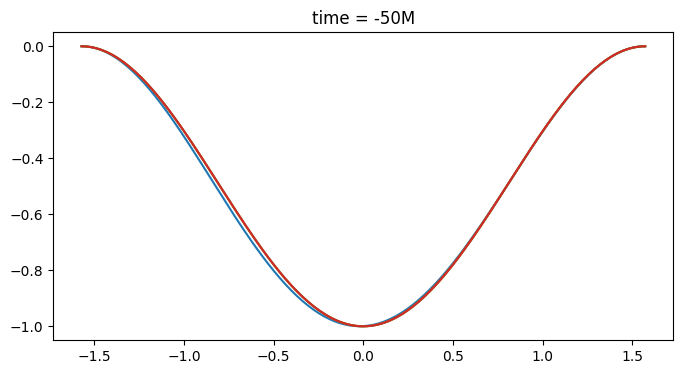

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

time_id = datetime.datetime.now()

def update(step):

    ax.clear() 

    ax.set_title(f'time = {step}M')

    for mapping in mappings:
        QNMs = [(lam, 0, n, p) for lam in np.arange(2, l_max+1) for n in np.arange(0,n_max+1) for p in (-1, +1)] + mapping 

        best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                                    sim.h,
                                                    modes=QNMs,
                                                    Mf=sim.Mf,
                                                    chif=sim.chif_mag,
                                                    t0=step,
                                                    mapping_modes=mapping,
                                                    spherical_modes=spherical_modes) 

        map = mapping[0]

        bf_ans = np.zeros_like(theta, dtype=complex)

        i = 0
        for loop in range(len(best_fit['C'])):
            if best_fit['modes'][loop]==map:
                A = best_fit['C'][loop]
                bf_ans += A * Y[:,:,wigner.Yindex(*best_fit['spherical_modes'][i])]
                i += 1
        bf_ans /= np.max(np.abs(bf_ans))

        ax.plot(phi_vals, bf_ans[:,100].real, label=f'{map}')

    return fig 

ax.legend()

ani = FuncAnimation(fig, update, frames=range(-50, 50, step), interval=100)
#ani.save(f'memory_mode_{time_id}.mp4', writer='ffmpeg')